# Imports, Functions and Variables
Ricardo Crespo, Miguel Melro

In [1]:
# Jupyter Notebook can  be used. Restart Kernel and run.
# This work is licensed under the Creative Commons Attribution-NonCommercial-NoDerivs (CC BY-NC-ND 4.0) License
# and is subject to patent application regulations.
# Author: João da Silva Pereira (joao.pereira@ipleiria.pt)

# Clear all variables from the workspace
#%reset -f

import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow import reshape
from keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from openpyxl import load_workbook

import json
from datetime import datetime, timedelta
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import OrderedDict

# FOR LNN/LTC
from tensorflow.keras import Model
import tensorflow_probability as tfp

K.clear_session()

WMethod = 1 # see the argument of getInitialier(). 1 is PSJ and <> of 1 is a random method. Should be a number between 1 and 15.
NLayer_ini = 1 # Inicial hidden layer number 
NLayermax = 2 #show -1 HLayers than this number
deltaNLayer = 1 # Delta increment for hidden layers
NEpochs = 100 # Epochs number alterado de 11 para 100
n_folds = 10  # Folders number. Should be higher than 2 
N_neuronio = 64 # Neurons number
Batch_len = 5   # Batch Size number

Xinput = 10000 # Input number 
Youtput = 3  # Output number
Namostra= 16  # Samples number for test validation

#Funções adicionadas para o data fetch do dataset de percipitação
def count_how_many_occurrences_of_each_value(arr):
    arr = np.ravel(arr)
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    ordered_counts = OrderedDict(sorted(counts.items()))
    return ordered_counts

def list_dataset_folders():
    folders = []
    folder_path = os.getcwd()
    folder_path = os.path.join(folder_path, "datasets")
    for name in os.listdir(folder_path):
        if os.path.isdir(os.path.join(folder_path, name)):
            if name.endswith("dataset"):
                folders.append(name)
    return folders


def resize_image(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Resize the image to 100x100 pixels
    resized_image = image.resize((100, 100))

    # Return the resized image
    return resized_image

#Ids das estações
ids = np.array([1240610, 1210718, 1210702, 1200562, 6212124, 1200575, 1200570, 1200571, 1240903, 1210734, 1210707, 1200558, 1200554, 1210683, 7240919, 1210770, 1240566, 1240675])

# Change Normalization Approach

# Data Treatment

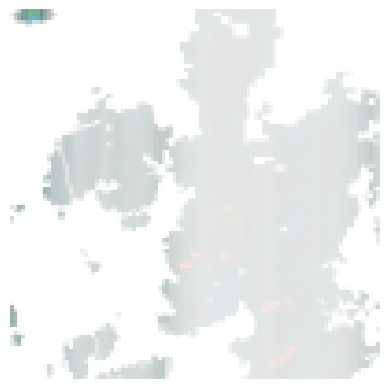

How many of each value in train:
OrderedDict([(np.float64(0.0), 13), (np.float64(1.0), 13), (np.float64(2.0), 13)])
How many of each value in validation:
OrderedDict([(np.float64(0.0), 7), (np.float64(1.0), 7), (np.float64(2.0), 4)])


In [2]:
#Data treatment para o dataset de percipitação
limit_dictionary = {key: 20 for key in range(101)} #para usar mais imagens de chuva, aumentar o valor do limite para cada categoria 
time_difference = 1 #diferença entre a hora da imagem e a hora do valor da chuva

image_size = 100 
counter_dictionary = {key: 0 for key in range(101)}
specific_datasets = list_dataset_folders()
data_array = np.empty(0)
images_array = np.empty((0, image_size, image_size, 4))

np.random.shuffle(specific_datasets)
np.random.shuffle(ids)

#for dataset in specific_datasets:
for stationID in ids:
    currentDir = 'datasets/dataset/precipitation/'+str(stationID)+'.json'
    with open(currentDir) as f:
        # Load the JSON data
        data = json.load(f)
    f.close()
    for date, hours in data.items():
        for hour in hours:
            hora_da_imagem = datetime.strptime(hour, "%H:%M")
            # Subtract one hour
            hora_da_imagem = hora_da_imagem - timedelta(hours=time_difference)
            # Convert back to string
            hora_da_imagem = hora_da_imagem.strftime("%H:%M")
            variable = date + 'T' + hora_da_imagem.replace(':', '') + '.png'  
            value = data[date][hour]
    
            if not os.path.exists('datasets/dataset/images/'+str(stationID)+'/'+date+'/'+variable):
                continue  # Skip the current iteration if the image doesn't exist
            if counter_dictionary[value] < limit_dictionary[value]:
                counter_dictionary[value] += 1
                data_array = np.append(data_array, value)
                image = resize_image('datasets/dataset/images/'+str(stationID)+'/'+date+'/'+variable)
                img_np = np.array(image)
                image.close()
                images_array = np.append(images_array,[img_np], axis=0) #NAO TIRAR PARENTESIS RETOS!!!!!!!!!!!!!!
                
                """# Duplicar imagens da classe(s) minoritária(s) (classe 1 e 2) Abordagem 3
                if value == 2:
                    for _ in range(177):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)
                elif value == 1:
                    for _ in range(50):  # Ajustar o número de duplicações para balancear com a classe 0
                        data_array = np.append(data_array, value)
                        images_array = np.append(images_array, [img_np], axis=0)"""

perm = np.random.permutation(len(data_array))
images_array, data_array = images_array[perm], data_array[perm]

train_images, test_images, train_labels, test_labels = train_test_split(images_array, data_array, test_size=0.3, random_state=2) 

train_images = tf.keras.utils.normalize(train_images, axis=1)
test_images = tf.keras.utils.normalize(test_images, axis=1)

#Print Imagem
plt.imshow(train_images[0])
plt.axis('off')  # Disable axis
plt.show()  

print("How many of each value in train:")
print(count_how_many_occurrences_of_each_value(train_labels))
print("How many of each value in validation:")
print(count_how_many_occurrences_of_each_value(test_labels))

# Initialize inputs tensors/arrays for Training and testing
x_train = train_images[:6*Namostra, :100, :100] 
x_test = test_images[:Namostra, :100, :100] 

# Initialize ouputs tensors/arrays for Training and testing
y_train = train_labels[:6*Namostra]
y_test = test_labels[:Namostra]


# Model Training

In [ ]:
# Initialize the model outside the loop
# ======================== OLD CNN ====================================== #
#model1 = Sequential()
#model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
#                input_shape=(100,100,4)))
#model1.add(BatchNormalization())
#model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
#model1.add(BatchNormalization())
#model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
#model1.add(Dropout(0.35)) #alterado de 0.35 para 0.3
#model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
#model1.add(BatchNormalization())
#model1.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
#model1.add(BatchNormalization())
#model1.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
#model1.add(Dropout(0.0035)) 
#model1.add(Flatten(name='flatten')) 
#model1.summary()
# ======================== OLD CNN ====================================== #

# ======================== NEW LTC + CNN ====================================== #
# Custom Liquid Time-Constant (LTC) Layer
class LTCLayer(layers.Layer):
    def __init__(self, units, dt=1.0, **kwargs):
        super(LTCLayer, self).__init__(**kwargs)
        self.units = units
        self.dt = dt  # Time interval between radar frames (e.g., 10 minutes)

    def build(self, input_shape):
        # Input shape: (batch, timesteps, features)
        self.w_input = self.add_weight(shape=(input_shape[-1], self.units),
                                        initializer='glorot_uniform',
                                        trainable=True)
        self.w_state = self.add_weight(shape=(self.units, self.units),
                                        initializer='orthogonal',
                                        trainable=True)
        self.tau = self.add_weight(shape=(self.units,),
                                    initializer=tf.keras.initializers.Constant(1.0),
                                    trainable=True)  # Time constants
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # inputs shape: (batch, timesteps, features)
        batch_size = tf.shape(inputs)[0]
        timesteps = inputs.shape[1]
        
        # Initial state (zeros)
        state = tf.zeros((batch_size, self.units))
        outputs = []

        # Iterate over timesteps (discretized LTC dynamics)
        for t in range(timesteps):
            x = inputs[:, t, :]  # Current timestep features
            # Compute input modulation
            modulated_input = tf.matmul(x, self.w_input)
            # Update state using Euler-like ODE step
            state_derivative = tf.nn.tanh(modulated_input + tf.matmul(state, self.w_state) + self.bias - state) / self.tau
            state = state + self.dt * state_derivative
            outputs.append(state)
        
        # Return final state (or sequence if return_sequences=True)
        return outputs[-1]  # Shape: (batch, units)

# Build Hybrid Model
def build_hybrid_model(input_shape, n_classes, timesteps=5):
    inputs = layers.Input(shape=(timesteps, 100, 100, 4))
    
    # Spatial Feature Extractor (CNN)
    cnn = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.35),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    
    # Process each timestep with CNN
    x = layers.TimeDistributed(cnn)(inputs)  # Output shape: (batch, timesteps, 128)
    
    # Temporal Dynamics (Liquid Neural Network)
    x = LTCLayer(units=64, dt=1.0)(x)  # Custom LTC layer
    x = layers.Dropout(0.35)(x)
    
    # Multi-Time Horizon Prediction
    outputs = []
    for horizon in [1, 2, 3]:  # Predict 1h, 2h, 3h ahead
        # Shared dense layers for all horizons
        y = layers.Dense(64, activation='relu')(x)
        y = layers.Dense(n_classes, activation='softmax', name=f'output_{horizon}h')(y)
        outputs.append(y)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Initialize Model
model1 = build_hybrid_model(input_shape=(5, 100, 100, 4), n_classes=3)  # Example: 3 rain classes
# ======================== NEW LTC + CNN ====================================== #

# Define the prediction function outside the loop
def predict_with_model(image):
    return model1.predict(image.reshape(5, 100, 100, 4), verbose=0) 
    
#function that implements the PSJ method for the 1st Deep Learning layer (João Silva Pereira)
def PSJmethod():
    z=np.zeros((N_neuronio, Xinput*4))     # reshaping here
    for i in range(0, N_neuronio):
        somas = []
        if i < Youtput:
            # arranjar forma de mandar 5 imagens?
            while(len(somas) < 5):
                soma = np.zeros([100,100,4]) 
                cont = 0
                for n in range(0, len(x_train)):
                    if y_train[n] == np.mod(i,Youtput):
                        soma += x_train[n]
                        cont += 1
                soma /= cont 

                somas.append(soma)
                i=i+1

            # Call the prediction function inside the loop
            soma_r = predict_with_model(soma)
            
            if i == 2:
                #print(soma.shape)
                print(soma)
                # Plot the array as an image
                plt.imshow(soma)
                plt.axis('off')  # Disable axis
                plt.show()

                print(soma_r.shape)
                #print(soma)
                # Plot the array as an image
                plt.imshow(soma_r.reshape(200,200))
                plt.axis('off')  # Disable axis
                plt.show()   
            
            soma = reshape(soma_r, [100*100*4])      # reshaping here 
            s = np.array(soma,dtype="cfloat")
            s = np.fft.fft(s)
            s = np.cos(np.angle(s))+np.sin(np.angle(s))*1j
            s = np.fft.ifft(s)
            z[i] = s.real
        else:
            z[i] = z[np.mod(i,Youtput)]
    return z

#function that implements the PSJ method for the outher Deep Learning layers (João Silva Pereira)
def iniL2(N_neur, inp):
    LastLayerANN=np.zeros((N_neur, inp))
    for r in range(0,N_neur):
        if np.mod(r,inp)==0:
            for k in range(0,inp):  
                for s in range(0,inp): 
                    if k==s:
                        if (r+k)<N_neur:
                            LastLayerANN[r+k][s]=1
    return LastLayerANN

   
# Initialize the seeds within tensorflow for results to be reproducible
# Seeds for NumPy and TensorFlow
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Settings for reproducibility (this may affect performance)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Function that initialize the Weights of the Deep Learning Network for 15 different methods
def getInitialier(WMethod):
    if WMethod==1:
        print("Method PSJ")
        PSJ = PSJmethod()
        print(PSJ)
        print(PSJ.shape)
        return tf.constant_initializer(PSJ), tf.constant_initializer(iniL2(N_neuronio, N_neuronio)), tf.keras.initializers.Ones()
    if WMethod==2:
        print("Method GlorotNormal")
        iniM = tf.keras.initializers.GlorotNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==3:
        print("Method GlorotUniform")
        iniM = tf.keras.initializers.GlorotUniform(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==4:
        print("Method HeNormal")
        iniM = tf.keras.initializers.HeNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==5:
        print("Method HeUniform")
        iniM = tf.keras.initializers.HeUniform(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==6:
        print("Method LecunNormal")
        iniM = tf.keras.initializers.LecunNormal(seed=seed_value)
        return iniM, iniM, iniM
    if WMethod==7:
        print("Method LecunUniform")
        iniM = tf.keras.initializers.LecunUniform(seed=seed_value) 
        return iniM, iniM, iniM
    if WMethod==8:
        print("Method Orthogonal")
        iniM = tf.keras.initializers.Orthogonal()
        return iniM, iniM, iniM
    if WMethod==9:
        print("Method RandomNormal")
        iniM = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        return iniM, iniM, iniM
    if WMethod==10:
        print("Method RandomUniform")
        iniM = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        return iniM, iniM, iniM
    if WMethod==11:
        print("Method Identity")
        iniM = tf.keras.initializers.Identity()
        return iniM, iniM, iniM
    if WMethod==12:
        print("Method TruncatedNormal")
        iniM = tf.keras.initializers.TruncatedNormal(mean=0., stddev=0.5) 
        return iniM, iniM, iniM
    if WMethod==13:
        print("Method VarianceScaling")
        iniM = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform') 
        return iniM, iniM, iniM 
    if WMethod==14:
        print("Method Zeros")
        iniM = tf.keras.initializers.Zeros()
        return iniM, iniM, iniM 
    if WMethod==15:
        print("Method Ones")
        iniM = tf.keras.initializers.Ones()
        return iniM, iniM, iniM 

# Create 3 initializer that will train the model
print("Ini Weight initialization")
initializer1, initializer2, initializer10 = getInitialier(WMethod)
print("End Weight initialization")

# Writer do xls to save data
xlsFileName = 'Train_method'+str(WMethod)+' N'+str(N_neuronio)+" MaxHiddenLayer"+str((NLayermax-1))+" "+" MaxFolds"+str(n_folds)+" "+ datetime.now().strftime("%Y %m %d-%H%M%S")+'.xlsx'
writer = pd.ExcelWriter(xlsFileName, engine='openpyxl')

# Create empty arrays
HidenLayeres =[]
train_accuracies_=[]
losses_=[]
accuracies_=[]
val_losses_=[] 
precisions_=[]  
val_precisions_=[]      
recalles_=[]     
val_recalles_=[] 

# Start the program for different configurations
try:   
    # Configuration the the hidden layers
    for n_HL in range(NLayer_ini, NLayermax, deltaNLayer): 
        NLayer=n_HL
        print("")
        print("Hidden Layer = ", NLayer)
        accuracies = []
        train_accuracies = []
        precisions = []
        val_precisions = []
        losses =[]
        val_losses = []
        recalles =[]
        val_recalles = []
        # Configuration of the different folds
        for fold in range(0, n_folds):
            fold += 1
            print(f"\nFold {fold}")
            print("")
                
            x_train_fold = x_train.reshape(-1, 100, 100, 4) 
            y_train_fold =  y_train    
            x_val_fold = x_test
            y_val_fold = y_test
            
            y_train_one_hot = to_categorical(y_train_fold, num_classes=Youtput) 
            y_val_one_hot = to_categorical(y_val_fold, num_classes=Youtput) 
            
            #Callback to save the Keras model or model weights at some frequency
            model_checkpoint = callbacks.ModelCheckpoint(filepath="model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max', save_weights_only=True)

            # Configuration of the Augmentation method
            datagen = ImageDataGenerator(
                rotation_range=5, 
                width_shift_range=0.02,
                height_shift_range=0.02,
                shear_range=0.02,
                zoom_range=0,
                fill_mode='nearest'
            )

            # ======================== OLD CNN ====================================== #
            # Deep Learning Network configuration
            #model = tf.keras.models.Sequential()   
            
            #model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                            #input_shape=(100,100,4)))
            #model.add(BatchNormalization())
            #model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            #model.add(BatchNormalization())
            #model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
            #model.add(Dropout(0.35)) 
            #model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
            #model.add(BatchNormalization())
            #model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
            #model.add(BatchNormalization())
            #model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
            #model.add(Dropout(0.0035))  
            #model.add(Flatten(name='flatten'))           
            #Bias_ini = 'zeros'
            #model.add(layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer1, bias_initializer=Bias_ini))
            # Configuration of the quantity of Hidden Layers
            #for f in range(1, NLayer+1):
            #    model.add(layers.Dense(N_neuronio, activation='relu', kernel_initializer=initializer2, bias_initializer=Bias_ini))
            #model.add(layers.BatchNormalization())  
            #model.add(tf.keras.layers.Dense(Youtput, activation='softmax', kernel_initializer=initializer10))

            # Compile Model
            #model.compile(optimizer=keras.optimizers.Adamax(learning_rate=0.0055), 
            #            loss='categorical_crossentropy',   
            #            #metrics=['accuracy'])  
            #            metrics=['accuracy', 'precision', 'recall'])  
            # ======================== OLD CNN ====================================== #


            # ======================== NEW LTC + CNN ====================================== #
            # Custom Liquid Time-Constant (LTC) Layer
            class LTCLayer(layers.Layer):
                def __init__(self, units, dt=1.0, **kwargs):
                    super(LTCLayer, self).__init__(**kwargs)
                    self.units = units
                    self.dt = dt  # Time interval between radar frames (e.g., 10 minutes)

                def build(self, input_shape):
                    # Input shape: (batch, timesteps, features)
                    self.w_input = self.add_weight(shape=(input_shape[-1], self.units),
                                                    initializer='glorot_uniform',
                                                    trainable=True)
                    self.w_state = self.add_weight(shape=(self.units, self.units),
                                                    initializer='orthogonal',
                                                    trainable=True)
                    self.tau = self.add_weight(shape=(self.units,),
                                                initializer=tf.keras.initializers.Constant(1.0),
                                                trainable=True)  # Time constants
                    self.bias = self.add_weight(shape=(self.units,),
                                                initializer='zeros',
                                                trainable=True)
                    super().build(input_shape)

                def call(self, inputs):
                    # inputs shape: (batch, timesteps, features)
                    batch_size = tf.shape(inputs)[0]
                    timesteps = inputs.shape[1]
                    
                    # Initial state (zeros)
                    state = tf.zeros((batch_size, self.units))
                    outputs = []

                    # Iterate over timesteps (discretized LTC dynamics)
                    for t in range(timesteps):
                        x = inputs[:, t, :]  # Current timestep features
                        # Compute input modulation
                        modulated_input = tf.matmul(x, self.w_input)
                        # Update state using Euler-like ODE step
                        state_derivative = tf.nn.tanh(modulated_input + tf.matmul(state, self.w_state) + self.bias - state) / self.tau
                        state = state + self.dt * state_derivative
                        outputs.append(state)
                    
                    # Return final state (or sequence if return_sequences=True)
                    return outputs[-1]  # Shape: (batch, units)

            # Build Hybrid Model
            def build_hybrid_model(input_shape, n_classes, timesteps=5):
                inputs = layers.Input(shape=(timesteps, 100, 100, 4))
                
                # Spatial Feature Extractor (CNN)
                cnn = tf.keras.Sequential([
                    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.35),
                    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
                    layers.BatchNormalization(),
                    layers.MaxPooling2D((2, 2)),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu')
                ])
                
                # Process each timestep with CNN
                x = layers.TimeDistributed(cnn)(inputs)  # Output shape: (batch, timesteps, 128)
                
                # Temporal Dynamics (Liquid Neural Network)
                x = LTCLayer(units=64, dt=1.0)(x)  # Custom LTC layer
                x = layers.Dropout(0.35)(x)
                
                # Multi-Time Horizon Prediction
                outputs = []
                for horizon in [1, 2, 3]:  # Predict 1h, 2h, 3h ahead
                    # Shared dense layers for all horizons
                    y = layers.Dense(64, activation='relu')(x)
                    y = layers.Dense(n_classes, activation='softmax', name=f'output_{horizon}h')(y)
                    outputs.append(y)
                
                model = Model(inputs=inputs, outputs=outputs)
                return model

            # Initialize Model
            model = build_hybrid_model(input_shape=(5, 100, 100, 4), n_classes=3)  # Example: 3 rain classes

            # Compile with Multi-Task Learning
            model.compile(
                optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision')],
                loss_weights=[0.3, 0.3, 0.4]  # Weight losses for 1h, 2h, 3h predictions
            )
            # ======================== NEW LTC + CNN ====================================== #

            
            # Adjust the data generator
            #datagen.fit(x_train_fold)
    
            #, verbose=0
            weights_dir = "model_weights_by_hour/hour_difference_" + str(time_difference) + ".weights.h5"
            #load best weights
            # Nao realizar este passo para comparação entre metodos de inicialização
            try:
                model.load_weights(weights_dir)
                print("Weights loaded")
            except:
                print("Weights not loaded")
                
            history = model.fit(datagen.flow(x_train_fold, y_train_one_hot,batch_size=Batch_len),
                                validation_data=(x_val_fold, y_val_one_hot), epochs=NEpochs, callbacks=[model_checkpoint]) 
            
            # Gets training and validation accuracy results
            train_accuracy = history.history['accuracy']
            val_accuracy = history.history['val_accuracy']
            
            # Show results
            epochs = range(1, len(train_accuracy) + 1)
            
            plt.figure(figsize=(8, 6))
            plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
            plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
    
            r=history #necessary, don't touch ;) 
            n=np.argmax(r.history['accuracy'])
            n_l=np.argmin(r.history['loss'])
            n_val=np.argmax(r.history['val_accuracy'])
            n_vl=np.argmin(r.history['loss'])
            n_p=np.argmax(r.history['precision'])
            n_vp=np.argmax(r.history['val_precision'])
            n_r=np.argmax(r.history['recall'])
            n_vr=np.argmax(r.history['val_recall'])
    

            print("   Accuracy Train[",NEpochs,"] = " + "%.4f" % np.round(r.history['accuracy'][NEpochs-1],4), " |  Max Accuracy Train[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['accuracy'][n],4), "        |  Accuracy Train[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['accuracy'][n_val],4))

            print("   Accuracy Test[",NEpochs,"] = " + "%.4f" % np.round(r.history['val_accuracy'][NEpochs-1],4), "  |  Validation Accuracy Test[",n+1,"] = ",\
                    "%.4f" % np.round(r.history['val_accuracy'][n],4), "  |  Max Valid. Accuracy Test[",n_val+1,"] = ",\
            "%.4f" % np.round(r.history['val_accuracy'][n_val],4))
            
            train_accuracies.append(np.round(r.history['accuracy'][n],4))
            losses.append(np.round(r.history['loss'][n_l],4))
            accuracies.append(np.round(r.history['val_accuracy'][n_val],4))
            val_losses.append(np.round(r.history['loss'][n_vl],4))
            precisions.append(np.round(r.history['precision'][n_p],4))        
            val_precisions.append(np.round(r.history['val_precision'][n_vp],4))        
            recalles.append(np.round(r.history['recall'][n_r],4))        
            val_recalles.append(np.round(r.history['val_recall'][n_vr],4))        
    
            data = {
                'Epoch' : epochs,
                'Accuracy': np.round(r.history['accuracy'],4),
                'Loss': np.round(r.history['loss'],4),
                'val_accuracy' : np.round(r.history['val_accuracy'],4),
                'val_loss' : np.round(r.history['val_loss'],4),      
                'precision': np.round(r.history['precision'],4),
                'val_precision': np.round(r.history['val_precision'],4),
                'recall': np.round(r.history['recall'],4),
                'val_recall': np.round(r.history['val_recall'],4)
            } 

            df = pd.DataFrame(data)
            
            # Save the DataFrame to the Excel sheet
            sheet_name = f'Fold_{fold}'+f'HLayer_{n_HL}'
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            K.clear_session()

        train_accuracies_.append(np.mean(train_accuracies))
        losses_.append(np.mean(losses))
        accuracies_.append(np.mean(accuracies))
        val_losses_.append(np.mean(val_losses))  
        precisions_.append(np.mean(precisions))  
        val_precisions_.append(np.mean(val_precisions))      
        recalles_.append(np.mean(recalles))      
        val_recalles_.append(np.mean(val_recalles))   

    # Show last plot for all Hidden Layers
    HiddenLayers = range(NLayer_ini, NLayermax, deltaNLayer)    
    plt.figure(figsize=(8, 6))
    plt.plot(HiddenLayers, train_accuracies_, 'bo', label='Training Accuracy')
    plt.plot(HiddenLayers, accuracies_, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Hidden Layer')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    data = {
            'HiddenLayer' : HiddenLayers,
            'Accuracy': train_accuracies_,
            'loss' : losses_,
            'val_accuracy' : accuracies_,
            'val_loss' : val_losses_,
            'precision' : precisions_,
            'val_precision' : val_precisions_,
            'recall' : recalles_,
            'val_recall' : val_recalles_
        }                                            
    df = pd.DataFrame(data) 
    # Save the DataFrame to the Excel sheet
    sheet_name = f'Fold_HL_Average{NLayermax}'
    df.to_excel(writer, sheet_name=sheet_name, index=False)

except KeyboardInterrupt:
    print('\n --- KeyboardInterrupt detected ---')
finally:
    print("")
    mean_Train_accuracy = np.mean(train_accuracies)
    print(f"\nAverage of Train Accuracy = {n_folds} folds: {mean_Train_accuracy * 100:.2f}%")
    print("")
    mean_accuracy = np.mean(accuracies)
    print(f"\nAverage of Validation Accuracy = {n_folds} folds: {mean_accuracy * 100:.2f}%")
    print("")
    print("train_accuracies_",train_accuracies_)
    print("losses_",losses_)
    print("accuracies_",accuracies_)
    print("precisions_",precisions_)  
    print("val_precisions_",val_precisions_)      
    print("recalles_",recalles_)      
    print("val_recalles_",val_recalles_) 
    print("")

    model.summary()
   
    #Close the Writer
    writer.close()#
    
    #move last sheet to first position
    # Carrega o workbook
    wb = load_workbook(xlsFileName)
    last_sheet_name = wb.sheetnames[-1]
    sheet_to_move = wb[last_sheet_name]
    wb.remove(sheet_to_move)
    wb._sheets = [sheet_to_move] + wb._sheets  # Usando _sheets para manipular diretamente a lista de folhas
    wb.save(xlsFileName)



2025-03-25 17:47:20.339912: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-25 17:47:20.340034: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-25 17:47:20.340041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1742924840.340451  564505 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742924840.340779  564505 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Ini Weight initialization
Method PSJ


ValueError: cannot reshape array of size 40000 into shape (5,100,100,4)